# Predicting the Energy Efficiency of Buildings

This project uses the UCI Energy Efficiency dataset to explore how building design parameters affect energy consumption.

The goal is to:
- Identify key drivers of heating and cooling loads
- Compare prediction models (Linear Regression vs Random Forest)
- Provide business recommendations for energy-efficient building design

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_excel("../data/ENB2012_data.xlsx")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


# Data Exploration

The dataset contains 8 building features (X1 - X8):
X1 - Relative Compactness
X2 - Surface Area
X3 - Wall Area
X4 - Roof Area
X5 - Overall Height
X6 - Orientation
X7 - Glazing Area
X8 - Glazing Area Distribution

and 2 target variables:
Y1 - Heating Load
Y2 - Cooling Load

Firstly, we will check data and missing values, study summary statistics, and analyze correlations between features and energy loads.

In [26]:
# Overview of data

print("Shape of dataset:", df.shape)
print(df.info())

Shape of dataset: (768, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None


In [21]:
# Missing data

print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64


In [24]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


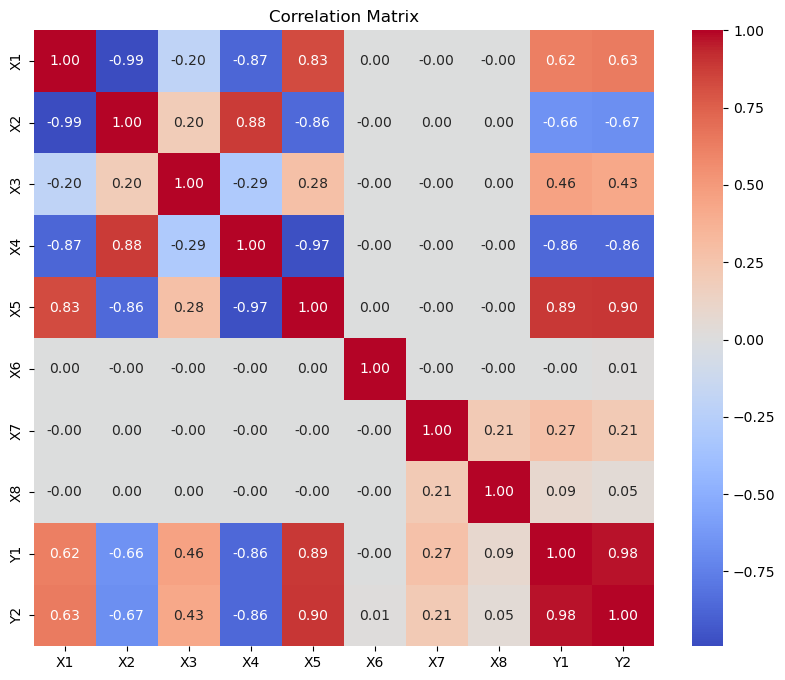

In [8]:
# Correlation heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig('Correlation Matrix.png')
plt.show()

- No missing values were found in the dataset.
- Heating and cooling loads are highly correlated (R² ≈ 0.98).
- Relative Compactness (X1) and especially Overall Height (X5) show strong positive influence on energy loads.
- Surface Area (X2) and especially Roof Area (X4) show strong negative correlation with energy loads.

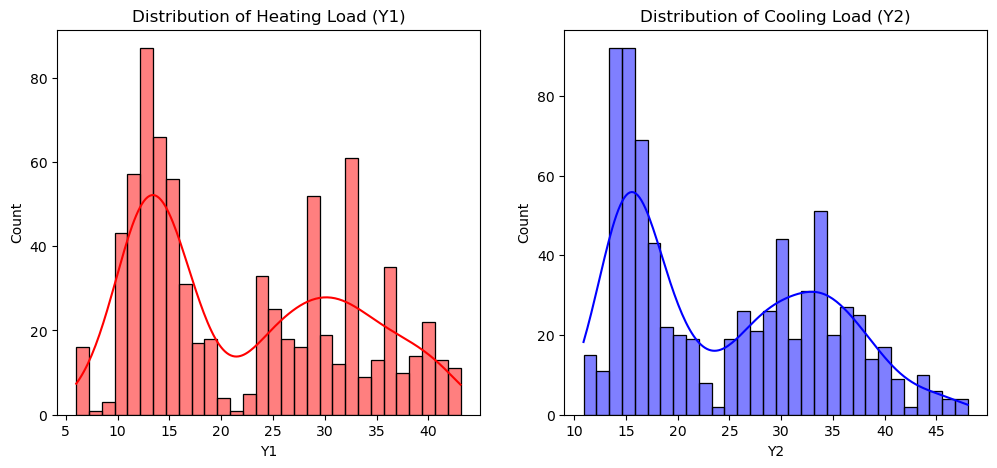

In [9]:
# Distribution of target variables

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df["Y1"], bins=30, kde=True, color="red")
plt.title("Distribution of Heating Load (Y1)")

plt.subplot(1,2,2)
sns.histplot(df["Y2"], bins=30, kde=True, color="blue")
plt.title("Distribution of Cooling Load (Y2)")
plt.savefig('Distributions.png')
plt.show()

Heating Load (Y1): The distribution is bimodal, with two main peaks around ~15 and ~30–35. This suggests two groups of buildings: one with lower heating demand and another with higher demand.
Cooling Load (Y2): Similarly, the distribution is bimodal, with peaks near ~15 and ~35. This indicates that cooling requirements also separate buildings into two clusters.
Since Y1 and Y2 are highly correlated (R² ≈ 0.98), their prediction models are expected to show similar behavior, although the distributions confirm some differences between them.

In [11]:
# Preparing model

X = df[['X1','X2','X3','X4','X5','X6','X7','X8']]

# Heating Load
y1 = df['Y1']

# Cooling Load
y2 = df['Y2']

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

In [13]:
# Model Training & Evaluation

## Linear Regression
lr_y1 = LinearRegression().fit(X_train, y1_train)
lr_y2 = LinearRegression().fit(X_train, y2_train)

## Random Forest
rf_y1 = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y1_train)
rf_y2 = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y2_train)

In [14]:
from sklearn.metrics import r2_score, mean_squared_error

# Linear Regression (Heating Load)
y1_pred_lr = lr_y1.predict(X_test)
r2_y1_lr = r2_score(y1_test, y1_pred_lr)
rmse_y1_lr = np.sqrt(mean_squared_error(y1_test, y1_pred_lr))
print(f"Linear Regression - Heating Load: R² = {r2_y1_lr:.3f}, RMSE = {rmse_y1_lr:.3f}")

# Random Forest (Heating Load)
y1_pred_rf = rf_y1.predict(X_test)
r2_y1_rf = r2_score(y1_test, y1_pred_rf)
rmse_y1_rf = np.sqrt(mean_squared_error(y1_test, y1_pred_rf))
print(f"Random Forest - Heating Load: R² = {r2_y1_rf:.3f}, RMSE = {rmse_y1_rf:.3f}")

# Linear Regression (Cooling Load)
y2_pred_lr = lr_y2.predict(X_test)
r2_y2_lr = r2_score(y2_test, y2_pred_lr)
rmse_y2_lr = np.sqrt(mean_squared_error(y2_test, y2_pred_lr))
print(f"Linear Regression - Cooling Load: R² = {r2_y2_lr:.3f}, RMSE = {rmse_y2_lr:.3f}")

# Random Forest (Cooling Load)
y2_pred_rf = rf_y2.predict(X_test)
r2_y2_rf = r2_score(y2_test, y2_pred_rf)
rmse_y2_rf = np.sqrt(mean_squared_error(y2_test, y2_pred_rf))
print(f"Random Forest - Cooling Load: R² = {r2_y2_rf:.3f}, RMSE = {rmse_y2_rf:.3f}")

Linear Regression - Heating Load: R² = 0.912, RMSE = 3.025
Random Forest - Heating Load: R² = 0.998, RMSE = 0.490
Linear Regression - Cooling Load: R² = 0.893, RMSE = 3.145
Random Forest - Cooling Load: R² = 0.968, RMSE = 1.710


Two models were trained and compared:
- Linear Regression (baseline model)
- Random Forest Regressor (non-linear model)

Metrics:
- R² (coefficient of determination): closer to 1 is better
- RMSE (Root Mean Squared Error): closer to 0 is better

Random Forest outperforms Linear Regression for both Heating and Cooling Load prediction.
Heating Load: RF achieved R² = 0.998 vs LR = 0.912.
Cooling Load: RF achieved R² = 0.968 vs LR = 0.893.
RMSE for Random Forest is significantly lower, especially for Heating Load (0.49 vs 3.02).

Top features for Heating Load:
X1    0.391148
X2    0.189600
X5    0.150991
X4    0.135333
X7    0.079689
X3    0.040632
X8    0.011872
X6    0.000736
dtype: float64
Top 3 features for Heating Load:
X1    0.391148
X2    0.189600
X5    0.150991
dtype: float64
Top features for Cooling Load:
X1    0.366699
X5    0.305471
X2    0.117935
X4    0.090767
X7    0.049076
X3    0.042424
X8    0.015639
X6    0.011989
dtype: float64
Top 3 features for Cooling Load:
X1    0.366699
X5    0.305471
X2    0.117935
dtype: float64


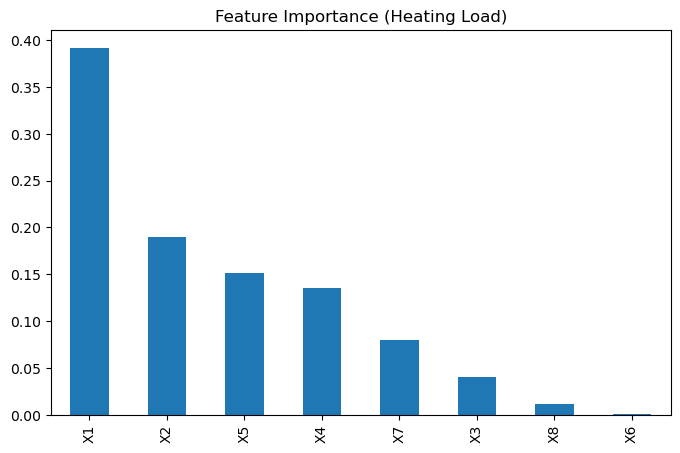

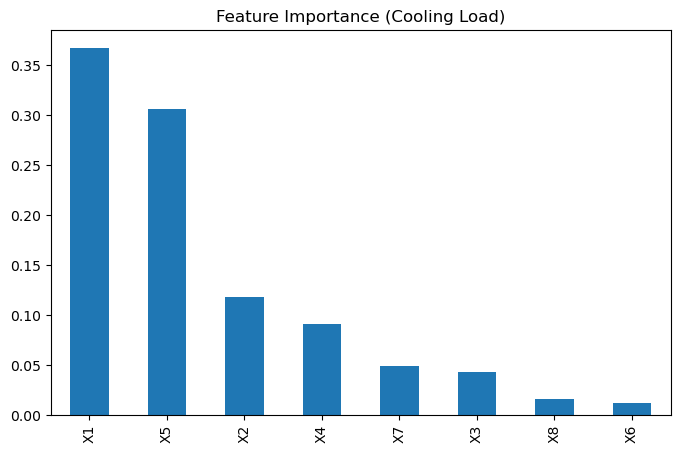

In [15]:
# Feature Importance:

# Heating Load
importances_y1 = pd.Series(rf_y1.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features for Heating Load:")
print(importances_y1)

# Top 3 features (Heating Load)
top3_y1 = importances_y1.head(3)
print("Top 3 features for Heating Load:")
print(top3_y1)

# Cooling Load
importances_y2 = pd.Series(rf_y2.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features for Cooling Load:")
print(importances_y2)

# Top 3 features (Cooling Load)
top3_y2 = importances_y2.head(3)
print("Top 3 features for Cooling Load:")
print(top3_y2)

plt.figure(figsize=(8,5))
importances_y1.plot(kind='bar', title='Feature Importance (Heating Load)')
plt.savefig('Feature Importance (Heating Load).png')
plt.show()

plt.figure(figsize=(8,5))
importances_y2.plot(kind='bar', title='Feature Importance (Cooling Load)')
plt.savefig('Feature Importance (Cooling Load).png')
plt.show()

The most important features for Heating Load: Relative Compactness (X1), Surface Area (X2), and Overall Height (X5).

The most important features for Cooling Load: Relative Compactness (X1), Overall Height (X5), and Surface Area (X2).

### Conclusions:

- Random Forest is the best-performing model for predicting building energy efficiency.
- Relative compactness, surface area, and overall height are the main design factors driving energy loads. Compact and well-proportioned buildings reduce both heating and cooling needs.
- The project demonstrates how data-driven insights can help design buildings for energy efficiency. Even small efficiency improvements translate into thousands of euros saved each year.